In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk, create_isoflux

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
#mesh_pts, mesh_lc, mesh_reg, coil_dict, cond_dict = load_gs_mesh('nextstep_mesh.h5')
mesh_pts, mesh_lc, mesh_reg, coil_dict, cond_dict = load_gs_mesh('nextstep_divcoil.h5')


In [3]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

d = -0.5
e = 1.7

coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)
coil_weights[1:3] = 5

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[1,0] = -1
coil_reg_mat[2,2] = 1
coil_reg_mat[2,1] = -1

targets[0] = -3E6

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1
mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11

coil_bounds[-4:, 0] = -122448.979592
coil_bounds[-4:, 1] = 122448.979592
mygs.set_coil_bounds(coil_bounds)

# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

# set boundary/saddle point targets
d0 = -0.5
d1 = d
if d1<d0:
    r, z, zeff = boundaryShape(kapu = 1.7*(1-d1)/(1-d0), kapl = 1.7*(1-d1)/(1-d0), delu = d1, dell = d1, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588*(1-d0)/(1-d1), eps = 0.2588*(1-d0)/(1-d1)/(1+0.2588*((1-d0)/(1-d1)-1)), zoffset = 0, upnull = True, lonull = True, npts = 8)
else:
    r, z, zeff = boundaryShape(kapu = 1.7*(1+d1)/(1+d0), kapl = 1.7*(1+d1)/(1+d0), delu = d1, dell = d1, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588*(1+d0)/(1+d1), eps = 0.2588*(1+d0)/(1+d1)/(1+0.2588*(1-(1+d0)/(1+d1))), zoffset = 0, upnull = True, lonull = True, npts = 8)
    
boundary = np.column_stack((r,z))
boundary = np.nan_to_num(boundary)
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 50*np.ones(2)
mygs.set_saddles(x_points, x_weights)

p1 = [1.06, 0.55]
p2 = [1.255, 0.495]


#p1 = [1.048, 0.51]
#p2 = [1.21, 0.493]

p1 = [1.048, 0.51]
p2 = [1.18, 0.485]

p1 = [1.11, 0.505]
p2 = [1.25, 0.46]

p1_l = np.copy(p1)
p1_l[1] = -p1[1]
p2_l = np.copy(p2)
p2_l[1] = -p2[1]

boundary = np.vstack((boundary, p1, p2,p1_l, p2_l))
#boundary = np.vstack((boundary, p1, p1_l))

isoflux_weights = 50*np.ones(len(boundary))
isoflux_weights[-4:] = 200
#isoflux_weights[-2:] = 1000

mygs.set_isoflux(boundary, isoflux_weights)

#find equilibrium
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()


#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.914E+00
    # of points  =    4421
    # of edges   =   13144
    # of cells   =    8724
    # of boundary points =     116
    # of boundary edges  =     116
    # of boundary cells  =     116
  Resolution statistics:
    hmin =  2.000E-03
    hrms =  3.848E-02
    hmax =  1.116

0

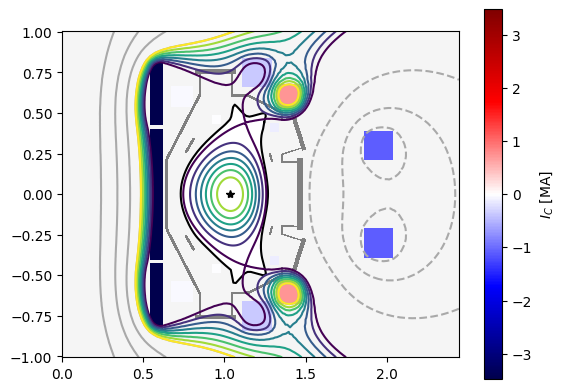

In [4]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
#mygs.plot_constraints(fig,ax)

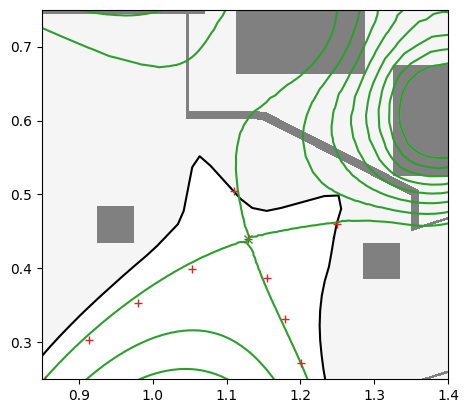

In [5]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,xpoint_color=None,xpoint_marker=None,plasma_color = 'tab:green',vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)
plt.xlim([0.85,1.4])
plt.ylim([0.25, 0.75])
p1 = [1.06, 0.55]
p2 = [1.255, 0.495]

p1 = [1.048, 0.51]
p2 = [1.18, 0.485]

p1 = [1.11, 0.505]
p2 = [1.25, 0.46]



#plt.scatter(p1[0], p1[1])
#plt.scatter(p2[0], p2[1])

(0.5, 2.1)

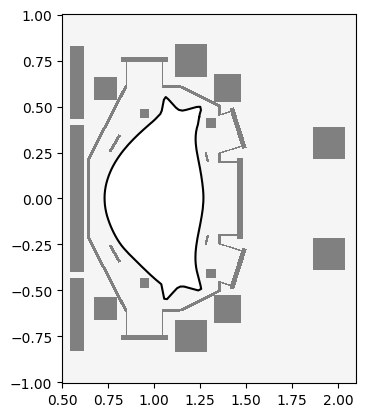

In [19]:
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
ax.set_xlim([0.5, 2.1])

In [7]:
mygs.print_info()

[1.12985758 0.43934976]
[ 1.12985379 -0.43936462]
hi
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.0000E+06
  Current Centroid [m]    =    1.028  0.000
  Magnetic Axis [m]       =    1.037  0.000
  Elongation              =    1.674 (U:  1.614, L:  1.734)
  Triangularity           =   -0.437 (U: -0.374, L: -0.500)
  Plasma Volume [m^3]     =    1.972
  q_0, q_95               =    0.384  1.330
  Peak Pressure [Pa]      =    4.4055E+05
  Stored Energy [J]       =    2.3016E+05
  <Beta_pol> [%]          =   52.4475
  <Beta_tor> [%]          =    3.5889
  Diamagnetic flux [Wb]   =    1.2348E-02
  Toroidal flux [Wb]      =    7.4542E-01
  l_i                     =    1.2640


In [8]:
current, map = mygs.get_coil_currents()
print(current)

[-3.46952824e+06 -3.46898474e+06 -3.47415516e+06 -4.52508836e+04
 -4.91703268e+04 -3.72208978e+05 -3.71988092e+05  7.25797176e+05
  7.26631997e+05 -1.09147712e+06 -1.09535427e+06 -1.70663662e+03
 -9.57069875e+02 -1.22448980e+05 -1.22448980e+05]


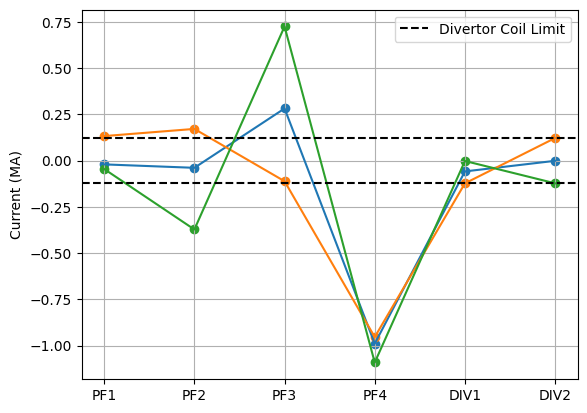

In [15]:
pfs = np.array(['PF1', 'PF2', 'PF3', 'PF4', 'DIV1', 'DIV2'])
curr_left = np.array([133012.9940729,  171781.12861478,-111151.60942989, -954020.31257451,-122677.76899901, 122448.979592  ])
curr_right = np.array([-4.52508836e+04,-3.72208978e+05, 7.25797176e+05, -1.09147712e+06, -1.70663662e+03,-1.22448980e+05  ])
curr_middle = np.array([-2.00632211e+04,-3.86425501e+04, 2.82304874e+05, -9.89544163e+05, -5.81042859e+04, -8.02607533e+02 ])
plt.plot(pfs, curr_middle/1E6)
plt.plot(pfs, curr_left/1E6)
plt.plot(pfs, curr_right/1E6)
plt.scatter(pfs, curr_middle/1E6)
plt.scatter(pfs, curr_left/1E6)
plt.scatter(pfs, curr_right/1E6)
plt.grid()
plt.axhline(y =122448.979592/1E6 , color = 'k', linestyle = '--', label = 'Divertor Coil Limit') 
plt.axhline(y =-122448.979592/1E6 , color = 'k', linestyle = '--') 
plt.ylabel('Current (MA)')
plt.legend()